# CDN (CloudFront) vs S3 vs NGINX

A statistical comparison of transfer speeds for static files served from a Content Delivery Network (CDN), Amazon's Simple Storage Service (S3) and an NGINX server in Singapore.

Content Delivery Networks serve as web proxies and allows caching of data nearer to the requesting user's location. Using a CDN can greatly increase transfer speeds if you are serving content to a global audience.

However, if you are serving content solely to a local region, static files served with a CDN may not be faster than files served using a regular storage service (i.e., AWS S3). This may be even more so in a small region like Singapore, where distances between data centers are relatively short.

As such, we will conduct a statistical comparison of the speeds for three different methods of serving a 100kb file. 

1. **AWS Simple Storage Service** <br> - Amazon's default cloud storage service
2. **AWS CloudFront CDN** <br> - Amazon's Content Delivery Network Service
3. **NGINX Web Server** <br> - A popular open source web server 

## Motivation

It is not immediately obvious if a CDN will be beneficial for applications serving solely serving the Singapore market. In AWS, the S3 service stores files in specific regions. And in South-East Asia region, AWS only has data centers in Singapore. Likewise, it's CDN service will serve the same files through the same data centers (together with edge locations). For each region (including Singapore), AWS maintains 3 availability zones. These zones contain one or more data centers and each zone is separated by a significant distance to spread the risk of a disaster bringing down all zones at once. This means that in the Singapore, one availability zone may be in Jurong area and the other in Tampines. The distance could be around ~20km.

Compare the scenario to the Ohio region where it is ~100x larger in area than Singapore. The availability zones are spread out much further. Thus, using a CDN will be more effective there. The case is not so clear for Singapore.

As such, is it still worthwhile to use a CDN in Singapore, solely for the Singapore market?

## Setup

### S3 Setup

We'll create a 256kb file for our experiment and upload this file to S3.
```{bash}
$ dd if=/dev/zero of=payload  bs=256KB  count=1
```

Once uploaded, and made public, the url path to the file should be in the format:
```{bash}
https://<bucket-name>.s3-ap-southeast-1.amazonaws.com/payload
```
Detailed instructions on how to uload to S3 here: https://docs.aws.amazon.com/AmazonS3/latest/user-guide/upload-objects.html


### CloudFront Setup

Next, you can enable the CDN service on the S3 bucket, so that the same file can be served through Amazon's CDN (CloudFront). The CDN url path would look something like:
```{bash}
https://<your-assigned-cloudfront-url>.cloudfront.net/payload
```

Detailed instructions on how to enable CDN on S3 can be found here: https://aws.amazon.com/premiumsupport/knowledge-center/cloudfront-https-requests-s3/

Now the file can be accessed both by S3 using the S3 filepath and the CDN using the cloudfront filepath

### Nginx file server Setup

Deploy an EC2 instance (t2.small). Since the nginx file server is not highly available, it exists only in one availability zone. We'll select a-southeast-1 availabilty zone for this. 

Deploy the instance with a bootstrap script to install Nginx and serve the payload file automatically when launched. Remember to configure the security groups to allow inbound http traffic on port 80

```{bash}
#!/bin/bash
yum update -y
amazon-linux-extras install nginx1.12 -y
cat > local.conf <<- EOM
server {
    listen 80;
    server_name _;
    root /usr/share/nginx;
    location / {
    }
}
EOM
mv local.conf /etc/nginx/conf.d/local.conf
dd if=/dev/zero of=/usr/share/nginx/html/payload  bs=256KB  count=1
systemctl restart nginx

```

You can test downloading the payload file from the deployed file server at this path:
```{bash}
http://<public-ipv4-address>/payload
```


Now all three environments serving the same file has been deployed. We can run the experiment

## From Local Machine

We'll start with a base case, accessing the static files from our local machine. 

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
CDN = "https://df3k2q0k3bu2n.cloudfront.net/static"
S3 = "https://amber-static.s3-ap-southeast-1.amazonaws.com/static"
NGINX = "http://3.0.61.50/payload"

In [3]:
with open("../data/sg-vpn-1-data.csv", "w") as f:

    n=1000
    req_az = "sg-vpn-1" # Request coming from local machine
    source = {
        "CLOUDFRONT": "https://df3k2q0k3bu2n.cloudfront.net/static/payload",
        "S3": "https://amber-static.s3-ap-southeast-1.amazonaws.com/static/payload",
        "NGINX": "http://3.0.61.50/payload",
    }
    
    headers = "timestamp,url,server,resp_time,status_code,size,origin"
    f.write(headers)
    f.write("\n")
    
    # Iterate through each mode of serving payload
    for server, url in source.items():    
        for i in range(1000):
            r = requests.get(url)
            timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')
            row = [
                timestamp, 
                url, 
                server, 
                str(r.elapsed.total_seconds()), 
                str(r.status_code), 
                str(len(r.content)), 
                req_az
            ]
            f.write(",".join(row))
            f.write("\n")
            print(i, server, r.elapsed.total_seconds(), r.status_code)

0 CLOUDFRONT 2.523459 200
1 CLOUDFRONT 1.185601 200
2 CLOUDFRONT 2.255079 200
3 CLOUDFRONT 1.234732 200
4 CLOUDFRONT 1.216561 200
5 CLOUDFRONT 1.269479 200
6 CLOUDFRONT 1.17435 200
7 CLOUDFRONT 1.284709 200
8 CLOUDFRONT 1.381209 200
9 CLOUDFRONT 1.152081 200
10 CLOUDFRONT 1.200939 200
11 CLOUDFRONT 1.233886 200
12 CLOUDFRONT 1.145838 200
13 CLOUDFRONT 1.165431 200
14 CLOUDFRONT 1.201601 200
15 CLOUDFRONT 1.187411 200
16 CLOUDFRONT 1.207079 200
17 CLOUDFRONT 1.211284 200
18 CLOUDFRONT 1.194489 200
19 CLOUDFRONT 1.20471 200
20 CLOUDFRONT 1.204013 200
21 CLOUDFRONT 1.237894 200
22 CLOUDFRONT 1.286384 200
23 CLOUDFRONT 1.347832 200
24 CLOUDFRONT 1.555182 200
25 CLOUDFRONT 2.557269 200
26 CLOUDFRONT 1.195889 200
27 CLOUDFRONT 3.067706 200
28 CLOUDFRONT 1.290488 200
29 CLOUDFRONT 1.220854 200
30 CLOUDFRONT 1.190264 200
31 CLOUDFRONT 1.270533 200
32 CLOUDFRONT 1.213662 200
33 CLOUDFRONT 1.217726 200
34 CLOUDFRONT 2.041656 200
35 CLOUDFRONT 1.201645 200
36 CLOUDFRONT 1.209932 200
37 CLOUDFRONT

KeyboardInterrupt: 

In [55]:
df_vpn_1 = pd.read_csv("../data/sg-vpn-1-data.csv")
df_vpn_2 = pd.read_csv("../data/sg-vpn-2-data.csv")
df_vpn_3 = pd.read_csv("../data/sg-vpn-3-data.csv")

In [56]:
df =df_vpn_1.append(df_vpn_2.append(df_vpn_3))

In [57]:
df.shape

(9000, 7)

In [58]:
df['resp_time'] = df['resp_time'] * 1000 # Convert to milliseconds
df['ln_resp_time'] = np.log(df['resp_time'])

In [59]:
df['status_code'].value_counts()

200    9000
Name: status_code, dtype: int64

In [60]:
df['size'].value_counts()

256000    9000
Name: size, dtype: int64

In [61]:
df['origin'].value_counts()

sg-vpn-2    3000
sg-vpn-3    3000
sg-vpn-1    3000
Name: origin, dtype: int64

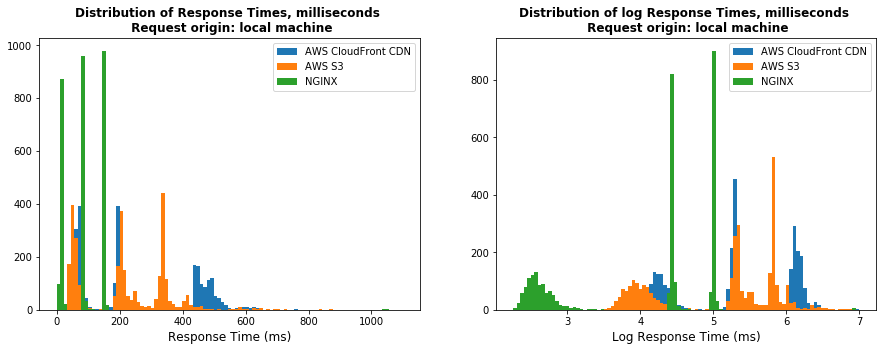

In [9]:
# Plot distribution of response times from local machine

cdn, ln_cdn = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='S3'].values)
nginx, ln_nginx = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='NGINX'].values)

bins = np.linspace(0, df['resp_time'].quantile(0.999), 100) # Less outliers
ln_bins = np.linspace(df['ln_resp_time'].min(), df['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: local machine', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: local machine', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Log Response Time (ms)", fontsize=12)

plt.show()

In [12]:
var_ln_cdn = list(ln_cdn).var(ddof=1)
var_ln_s3 = ln_s3.var(ddof=1)
var_ln_nginx = ln_nginx.var(ddof=1)

AttributeError: 'tuple' object has no attribute 'var'

In [ ]:
s = np.sqrt((var_ln_nginx+var_ln_s3)/2)

In [ ]:
t = (ln_nginx.mean() - ln_s3.mean())/(s*np.sqrt(2.0/1000))

In [ ]:
t

In [473]:
df = 2*(1000-2)

In [474]:
p = 1 - stats.t.cdf(t, df=df)

In [475]:
p

1.0

In [382]:
t2, p2 = stats.ttest_ind(ln_nginx, ln_s3, equal_var=False)

In [383]:
t2

-158.75436806449343

In [384]:
p2

0.0

## Comparing speeds from different locations

In [74]:
df = pd.read_csv("../data/local-data.csv")
df_a = pd.read_csv("../data/ap-southeast-1a-data.csv")
df_b = pd.read_csv("../data/ap-southeast-1b-data.csv")
df_c = pd.read_csv("../data/ap-southeast-1c-data.csv")

In [75]:
df_az = df_a.append(df_b).append(df_c)

In [76]:
df_az.shape

(9000, 7)

In [77]:
df_az['resp_time'] = df_az['resp_time'] * 1000 # Convert to milliseconds
df_az['ln_resp_time'] = np.log(df_az['resp_time'])

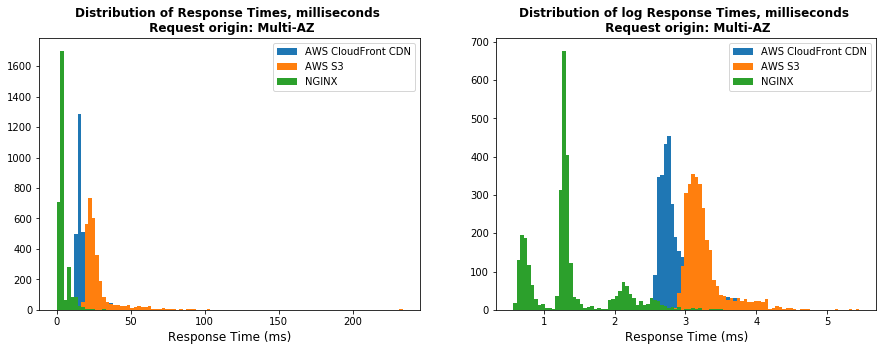

In [78]:
# Plot distribution of response times from local machine

cdn, ln_cdn = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='S3'].values)
nginx, ln_nginx = zip(*df_az[['resp_time','ln_resp_time']].loc[df_az['server']=='NGINX'].values)

bins = np.linspace(0, df_az['resp_time'].quantile(0.999), 100)
ln_bins = np.linspace(df_az['ln_resp_time'].min(), df_az['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: Multi-AZ', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: Multi-AZ', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Response Time (ms)", fontsize=12)


plt.show()

In [18]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1a')].mean()

3.531129

In [19]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1b')].mean()

6.646465

In [20]:
df_az['resp_time'].loc[(df_az['server']=='NGINX') & (df_az['origin']=='ap-southeast-1c')].mean()

4.519234

In [23]:
np.mean(s3)

28.335949333333332

In [24]:
np.mean(nginx)

4.898942666666667

## OLS Regression - AWS AZ

In [79]:
import statsmodels.formula.api as smf

In [80]:
df.columns

Index(['timestamp', 'url', 'server', 'resp_time', 'status_code', 'size',
       'origin'],
      dtype='object')

In [81]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df_az['server']).drop('S3', axis=1)

# Get Availability Zone dummies - 1a as base
az_dummies = pd.get_dummies(df_az['origin'], drop_first=True)

In [86]:
df_az = pd.concat([df_az, server_dummies], axis=1)
df_az = pd.concat([df_az, az_dummies], axis=1)

In [91]:
df_az

,timestamp,url,server,resp_time,status_code,size,origin,ln_resp_time,CLOUDFRONT,NGINX,ap_southeast_1b,ap_southeast_1c
0,2019-10-14 07:31:17.281124,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,57.333,200,256000,ap-southeast-1a,4.048876,1,0,0,0
1,2019-10-14 07:31:17.310067,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,21.181,200,256000,ap-southeast-1a,3.053105,1,0,0,0
2,2019-10-14 07:31:17.339916,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,20.201,200,256000,ap-southeast-1a,3.005732,1,0,0,0
3,2019-10-14 07:31:17.368034,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,21.043,200,256000,ap-southeast-1a,3.046568,1,0,0,0
4,2019-10-14 07:31:17.398650,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,23.579,200,256000,ap-southeast-1a,3.160356,1,0,0,0
5,2019-10-14 07:31:17.428196,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,21.673,200,256000,ap-southeast-1a,3.076067,1,0,0,0
6,2019-10-14 07:31:17.457367,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,20.149,200,256000,ap-southeast-1a,3.003155,1,0,0,0
7,2019-10-14 07:31:17.485039,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,20.348,200,256000,ap-southeast-1a,3.012983,1,0,0,0
8,2019-10-14 07:31:17.512652,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,19.490,200,256000,ap-southeast-1a,2.969902,1,0,0,0
9,2019-10-14 07:31:17.544133,https://df3k2q0k3bu2n.cloudfront.net/static/pa...,CLOUDFRONT,23.007,200,256000,ap-southeast-1a,3.135799,1,0,0,0


In [90]:
df_az.rename(columns={
    "ap-southeast-1a" : "ap_southeast_1a",
    "ap-southeast-1b" : "ap_southeast_1b",
    "ap-southeast-1c" : "ap_southeast_1c"
}, inplace=True)

In [93]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + ap_southeast_1b + ap_southeast_1c ", data=df_az).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_resp_time   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     9675.
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:45:02   Log-Likelihood:                -4527.4
No. Observations:                9000   AIC:                             9065.
Df Residuals:                    8995   BIC:                             9100.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1861      0.009    3

In [654]:
100*(np.exp(-0.4016)-1)

-33.0751608485781

In [645]:
np.exp(-1.9215)*100

14.638721653755152

## OLS Regression - VPN

In [43]:
import statsmodels.formula.api as smf

In [62]:
df.columns

Index(['timestamp', 'url', 'server', 'resp_time', 'status_code', 'size',
       'origin', 'ln_resp_time'],
      dtype='object')

In [63]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df['server']).drop('S3', axis=1)

# Get Availability Zone dummies - 1a as base
az_dummies = pd.get_dummies(df['origin'], drop_first=True)

In [65]:
df = pd.concat([df, server_dummies], axis=1)
df = pd.concat([df, az_dummies], axis=1)

In [69]:
df.rename(columns={
    "sg-vpn-2":"sg_vpn_2",
    "sg-vpn-3" : "sg_vpn_3"
}, inplace=True)

In [72]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + sg_vpn_2 + sg_vpn_3 ", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_resp_time   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 3.910e+04
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:40:47   Log-Likelihood:                -76.087
No. Observations:                9000   AIC:                             162.2
Df Residuals:                    8995   BIC:                             197.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9444      0.006    685.587      0.0